In [1]:
# Needed Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import seaborn as sns
import networkx as nx
from torch.utils.data import DataLoader
import torchvision.transforms as transf
from data_feed import DataFeed, DataFeed_image_pos
from build_net import resnet50, NN_beam_pred, MultinomialLogisticRegression


In [2]:
# Fixing the seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)


if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# or full reproducibility
#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Now you can use the `device` variable to move your model and data to the correct device
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Directory containing the saved CSV files
output_dir = "./feature_IID/"

# Load one of the CSV files for EDA (e.g., user_0_outputs.csv)
df = pd.read_csv(output_dir + "user_0_pos_height_beam.csv")

# Quick overview of the data
print("Data Overview:")
print(df.head())
print("\nData Summary:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

Data Overview:
   index_x  unit2_lat  unit2_lon  unit2_height  unit2_distance  \
0     9862   0.188929   0.431909      1.000000        0.167641   
1     4449   0.410610   0.286188      0.231752        0.361212   
2    10299   0.365071   0.424029      0.174270        0.246799   
3     9229   0.335884   0.431909      0.656934        0.210932   
4     6947   0.175857   0.390571      0.056569        0.242568   

                                           unit1_rgb  unit1_beam_x  \
0  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
1  ./../Carla/datasets/scenario23_dev//unit1/came...            14   
2  ./../Carla/datasets/scenario23_dev//unit1/came...            20   
3  ./../Carla/datasets/scenario23_dev//unit1/came...            17   
4  ./../Carla/datasets/scenario23_dev//unit1/came...            14   

   lat_region  lon_region  region  
0           0           1       1  
1           1           0       2  
2           1           1       3  
3           1          

In [18]:
########################################################################
########################### Data pre-processing ########################
########################################################################
from torch.utils.data import ConcatDataset
no_users = 1
all_datasets_splits = 20
batch_size = 64
img_resize = transf.Resize((224, 224))
img_norm = transf.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
proc_pipe = transf.Compose(
    [transf.ToPILImage(),
     img_resize,
     transf.ToTensor(),
     img_norm]
)
dataset_dir = "feature_IID/"
train_loaders = []
test_loaders = []
val_loaders = []
train_combined_dataset = []
val_combined_datasets = []
for user_id in range(all_datasets_splits):
    train_dir = dataset_dir + f'user_{user_id}_pos_height_beam_train.csv'
    val_dir = dataset_dir + f'user_{user_id}_pos_height_beam_val.csv'
    test_dir = dataset_dir + f'user_{user_id}_pos_height_beam_test.csv'
    
    train_dataset = DataFeed_image_pos(train_dir, transform=proc_pipe)
    val_dataset = DataFeed_image_pos(root_dir=val_dir, transform=proc_pipe)
    test_dataset = DataFeed_image_pos(root_dir=test_dir, transform=proc_pipe)
    train_combined_dataset.append(train_dataset)
    val_combined_datasets.append(val_dataset)

train_dataset = ConcatDataset(train_combined_dataset)
val_dataset = ConcatDataset(val_combined_datasets)


train_loader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              #num_workers=8,
                              shuffle=False)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        #num_workers=8,
                        shuffle=False)

print("All loadred are loaded")

All loadred are loaded


In [19]:
# Model Preperation#
all_models = []
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}


In [21]:
# Configuration
import random
no_users = 3  # Example: Number of users
available_modalities = ["pos_height", "images"]
modality_size = {"pos_height": 128, "images": 128}
group_definitions = {
    1: ["pos_height"],        # Group 1: Only pos_height
    2: ["images"],            # Group 2: Only images
    3: ["pos_height", "images"]  # Group 3: Both modalities
}

# Assign each user to a group randomly
weights = [0.2, 0.3, 0.5]  # Probabilities for groups 1, 2, and 3

# Generate user_groups with weighted random choices
user_groups = [1, 2, 3] #random.choices([1, 2, 3], weights=weights, k=no_users)

# Assign modalities to users based on their group
user_modalities = [group_definitions[group] for group in user_groups]

# Compute output sizes for each user based on their modalities
output_sizes = [sum(modality_size[modality] for modality in user_modality) for user_modality in user_modalities]

# Store models (placeholders for actual models)
all_models = []

# Example output (for verification)
print(f"User Groups: {user_groups[:10]}")  # Show first 10 users' groups
print(f"User Modalities: {user_modalities[:10]}")  # Show first 10 users' modalities
print(f"Output Sizes: {output_sizes[:10]}")  # Show first 10 users' output sizes

User Groups: [1, 2, 3]
User Modalities: [['pos_height'], ['images'], ['pos_height', 'images']]
Output Sizes: [128, 128, 256]


In [22]:
def sinkhorn_knopp(matrix, tol=1e-9, max_iter=1000):
    """
    Converts a given matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    Parameters:
        matrix (np.ndarray): The input matrix to be transformed.
        tol (float): The tolerance for convergence.
        max_iter (int): Maximum number of iterations for convergence.
    
    Returns:
        np.ndarray: A doubly stochastic matrix.
    """
    matrix = matrix.copy()
    for _ in range(max_iter):
        # Normalize rows
        row_sums = matrix.sum(axis=1, keepdims=True)
        matrix /= row_sums

        # Normalize columns
        col_sums = matrix.sum(axis=0, keepdims=True)
        matrix /= col_sums

        # Check for convergence
        if np.allclose(matrix.sum(axis=1), 1, atol=tol) and np.allclose(matrix.sum(axis=0), 1, atol=tol):
            break

    return matrix
    
def create_random_topology(num_users, similarity_matrix, edge_probability=0.3):
    """
    Creates a connected random topology using NetworkX.
    Returns the adjacency matrix.
    """
    while True:
        graph = nx.erdos_renyi_graph(num_users, edge_probability)
        adjacency_matrix = nx.to_numpy_array(graph)
        new_adj = np.multiply(adjacency_matrix, similarity_matrix)
        new_graph = nx.from_numpy_array(new_adj)
        if nx.is_connected(new_graph):
            break

    # Convert graph to adjacency matrix
    adjacency_matrix = nx.to_numpy_array(new_graph)
    return adjacency_matrix

def prepare_mixing_matrices(adjacency_matrix, similarity_matrices):
    """
    Computes a mixing matrix for each modality by multiplying the adjacency matrix 
    with the similarity matrix for that modality.
    Returns a dictionary of mixing matrices.
    """
    adjacency_matrices = {}
    mixing_matrices = {}
    for modality, similarity_matrix in similarity_matrices.items():
        # Element-wise multiplication of adjacency and similarity matrices
        combined_matrix = adjacency_matrix * similarity_matrix
        adjacency_matrices[modality] = combined_matrix
        
        # Normalize to create a doubly matrix
        mixing_matrix = sinkhorn_knopp(combined_matrix)
        
        
        mixing_matrices[modality] = mixing_matrix
    
    return mixing_matrices, adjacency_matrices




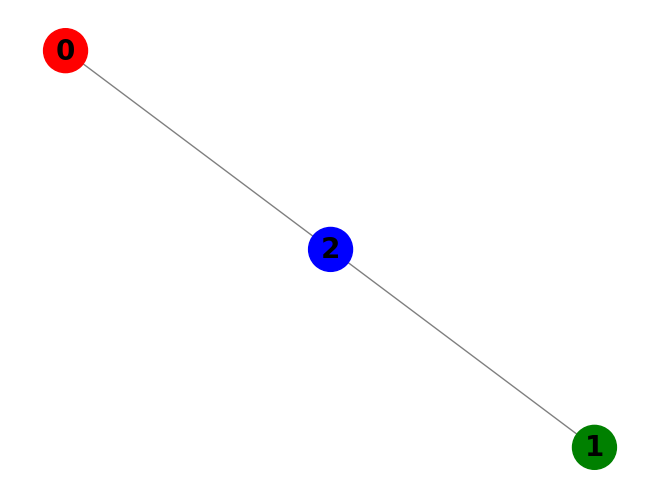

In [24]:
# Draw the graph
# Define colors for the groups
group_colors = {1: 'red', 2: 'green', 3: 'blue'}
node_colors = [group_colors[group] for group in user_groups]
G = nx.from_numpy_array(similarity_matrix)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, edge_color='gray', node_size=1000, node_color=node_colors, font_size=20, font_color='black')

# Show the plot
plt.show()

In [27]:
# Image Network
class ImageNet(nn.Module):
    def __init__(self):
        super(ImageNet, self).__init__()
        self.feature_extractor = resnet50(pretrained=True, progress=True, num_classes=64)  # ResNet50 for image input
        self.bn = nn.BatchNorm1d(128)  # Batch Normalization for image stream
        self.fc = MultinomialLogisticRegression(input_size=128, num_classes=64)  # Adjust input_size & num_classes

    
    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bn(x)
        x = self.fc(x)
        return x


# Position Network
class PosNet(nn.Module):
    def __init__(self):
        super(PosNet, self).__init__()
        self.feature_extractor = NN_beam_pred(num_features=4, num_output=64)  # Neural network for position input
        self.bn = nn.BatchNorm1d(128)  # Batch Normalization for position stream
        self.fc = MultinomialLogisticRegression(input_size=128, num_classes=64)  # Adjust input_size & num_classes


    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.bn(x)
        x = self.fc(x)
        return x


In [28]:
lr = 1e-3
optimizers = []
for user_id in range(no_users):
    user_model = {}
    local_optimizer = {}
    if "images" in user_modalities[user_id]:
        user_model["images"] = ImageNet().to(device)
        #user_model["images"] = resnet50(pretrained=True, progress=True, num_classes=64)
        local_optimizer["images"] = optim.Adam(user_model["images"].parameters(), lr=lr)
    if "pos_height" in user_modalities[user_id]:
        user_model["pos_height"] = PosNet().to(device)
        #user_model["pos_height"] = NN_beam_pred(num_features=4, num_output=64)
        local_optimizer["pos_height"] = optim.Adam(user_model["pos_height"].parameters(), lr=lr)
    all_models.append(user_model)
    optimizers.append(local_optimizer)
base_models = {"images": ImageNet().to(device), "pos_height": PosNet().to(device)}

Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>
Output layer dim = 64
<class 'build_net.Bottleneck'>


In [29]:


# Decentralized aggregation function
def decentralized_aggregation(user_models, mixing_matrices, available_modalities):
    num_users = len(user_models)
    
    for modality in available_modalities:
        # Get the mixing matrix for the current modality
        mixing_matrix = mixing_matrices[modality]
        
        # Convert user model parameters to vectors for aggregation
        aggregated_models = []
        aggregated_updates = []
        for user_model in user_models:
            if modality in user_model.keys(): 
                aggregated_models.append(torch.nn.utils.parameters_to_vector(user_model[modality].parameters()))
                aggregated_updates.append(torch.zeros_like(aggregated_models[-1]))
            else:
                aggregated_models.append(0)
                aggregated_updates.append(0)
        
        
        # Perform model aggregation based on the mixing matrix for this modality
        for i in range(num_users):
            for j in range(num_users):
                if mixing_matrix[i, j] > 0:
                    aggregated_updates[i] += mixing_matrix[i, j] * aggregated_models[j]
        
        # Update user models with aggregated parameters for the current modality
        for i in range(num_users):
            if modality in user_models[i].keys():
                torch.nn.utils.vector_to_parameters(aggregated_updates[i], user_models[i][modality].parameters())


def train_local_model(local_modalities, models, train_loader, criterion, optimizers, epochs):

    training_losses = []
    training_accuracies = []

    max_acc = 0
    max_loss = 0

    for modality in local_modalities:
        #print(f"Training for modality: {modality}")

        model = models[modality]
        optimizer = optimizers[modality]

        for epoch in range(epochs):
            model.train()  # Set model to training mode

            epoch_loss = 0.0
            correct_predictions = 0
            total_samples = 0

            for data_batch, labels in train_loader:
                # Get the data for the current modality
                data = data_batch[modality]
                

                # Move data to GPU if available
                data, labels = data.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(data)

                # Compute loss
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Update loss and accuracy metrics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, dim=1)
                correct_predictions += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            # Calculate average loss and accuracy for the epoch
            avg_loss = epoch_loss / len(train_loader)
            accuracy = correct_predictions / total_samples

            # Store metrics for debugging
            training_losses.append(avg_loss)
            training_accuracies.append(accuracy)

            #print(
            #    f"Epoch [{epoch + 1}/{epochs}], Modality: {modality}, "
            #    f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}"
            #)

    return min(training_losses), max(training_accuracies)


In [30]:
def validate_user_models(user_id, user_models, val_loaders, criterion):

    total_acc = []
    total_los = []
    with torch.no_grad():  # Disable gradient computation for validation
        for modality, model in user_models.items():
            total_loss = 0.0
            total_correct = 0
            total_samples = 0
            model.eval()
            if modality not in user_models.keys():
                print(f"Skipping modality {modality} for User {user_id + 1}, no validation data.")
                continue
            
            for data, labels in val_loaders:  # Iterate over validation data for the modality
                data = data[modality]
                data, labels = data.to(device), labels.to(device)

                # Forward pass
                outputs = model(data)
                loss = criterion(outputs, labels)

                # Accumulate loss and accuracy
                total_loss += loss.item() * labels.size(0)  # Sum loss for the batch
                _, predicted = torch.max(outputs, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += labels.size(0)

            # Compute metrics
            avg_loss = total_loss / total_samples if total_samples > 0 else 0.0
            accuracy = total_correct / total_samples if total_samples > 0 else 0.0
            total_acc.append(accuracy)
            total_los.append(avg_loss)
        
            #print(f"User {user_id + 1}, modality: {modality} - Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
        return {'loss': min(total_los), 'accuracy': max(total_acc)}


In [31]:
# Hyperparameters
lambda_reg = 0.01
eta = 0.01

# Dictionaries to store metrics
group_train_loss_histories = {1: [], 2: [], 3: []}
group_train_accuracy_histories = {1: [], 2: [], 3: []}
group_val_loss_histories = {1: [], 2: [], 3: []}
group_val_accuracy_histories = {1: [], 2: [], 3: []}
criterion = nn.CrossEntropyLoss()

global_rounds = 100
local_epochs = 1
# Decentralized Federated Learning Loop
for round_num in range(global_rounds):

    # Decentralized aggregation
    #decentralized_aggregation(all_models, mixing_matrices, available_modalities)
    epoch_group_train_losses = {1: [], 2: [], 3: []}
    epoch_group_train_accuracies = {1: [], 2: [], 3: []}
    epoch_group_val_losses = {1: [], 2: [], 3: []}
    epoch_group_val_accuracies = {1: [], 2: [], 3: []}

    
    print(f"Global Round {round_num + 1}")

    # Training for image modalities
    
    epoch_train_loss = 0.0
    correct_train_predictions = 0
    total_train_samples = 0

    for user_id in range(no_users):
        #print(f"Training model for User {user_id + 1}")
        print(user_id)
        user_models = all_models[user_id]
        group = user_groups[user_id]
        
        # Initialize optimizers for each modality
        
        # Train local model
        train_losses, train_accuracies = train_local_model(
            user_modalities[user_id],
            user_models,
            train_loader,
            criterion,
            optimizers[user_id],
            local_epochs
        )
        epoch_group_train_losses[group].append(train_losses)
        epoch_group_train_accuracies[group].append(train_accuracies)

        # Assign metrics to the respective group
        


    
    # Validation phase
    
    for user_id in range(no_users):
        user_models = all_models[user_id]
        val_dict = validate_user_models(
            user_id,
            user_models,
            val_loader,
            criterion
        )
        group = user_groups[user_id]
        epoch_group_val_losses[group].append(val_dict["loss"])
        epoch_group_val_accuracies[group].append(val_dict["accuracy"])

    # Print group-wise metrics
    #print(f"Metrics for Global Round {round_num + 1}:")
    for group in [1, 2, 3]:

        group_train_loss_histories[group].append(epoch_group_train_losses[group])
        group_train_accuracy_histories[group].append(epoch_group_train_accuracies[group])
        group_val_loss_histories[group].append(epoch_group_val_losses[group])
        group_val_accuracy_histories[group].append(epoch_group_val_accuracies[group])

    print(f"{global_rounds}] Group Metrics:")
    for group in [1, 2, 3]:
        print(f"  Group {group} - Train Loss: {np.mean(group_train_loss_histories[group][-1]):.4f}, Train Accuracy: {np.mean(group_train_accuracy_histories[group][-1]):.4f}")
        print(f"  Group {group} - Val Loss: {np.mean(group_val_loss_histories[group][-1]):.4f}, Val Accuracy: {np.mean(group_val_accuracy_histories[group][-1]):.4f}")


Global Round 1
0
1


KeyboardInterrupt: 

In [ ]:
'''
class MultiStreamNet(nn.Module):
    def __init__(self):
        super(MultiStreamNet, self).__init__()

        # Define the streams
        self.stream_1 = resnet50(pretrained=True, progress=True, num_classes=64)  # First stream using resnet50
        self.stream_2 = NN_beam_pred(num_features=4, num_output=64)  # Second stream using NN_beam_pred
        
        # Add Batch Normalization layers
        self.bn_stream_1 = nn.BatchNorm1d(128)  # Adjust according to the output size of resnet50
        self.bn_stream_2 = nn.BatchNorm1d(128)   # Adjust according to the output size of NN_beam_pred

        # Combine the two streams and apply Multinomial Logistic Regression
        self.fc = MultinomialLogisticRegression(input_size=256, num_classes=64)  # Adjust input_size & num_classes

    def forward(self, x1, x2):
        # Process through stream 1 (resnet50)
        out1 = self.stream_1(x1)
        out2 = self.bn_stream_1(out1)
        print(out1.shape)
        print(out2.shape)
        
        # Process through stream 2 (NN_beam_pred)
        out2 = self.stream_2(x2)
        out2 = self.bn_stream_2(out2)

        # Concatenate the outputs from both streams
        out = torch.cat((out1, out2), dim=1)
        
        # Final classification layer
        out = self.fc(out)
        
        return out

# Instantiate the model
model = MultiStreamNet().to(device)

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example training loop
def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for data in train_loader:
            x, y = data  # Assuming inputs1 and inputs2 are from different streams
            x["images"], x["pos_height"], y = x["images"].to(device), x["pos_height"].to(device), y.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x["images"], x["pos_height"])
            
            # Calculate loss
            loss = criterion(outputs, y)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Assuming `train_loader` is a DataLoader object containing the training data
train(model, train_loaders[0], criterion, optimizer)

'''

In [ ]:
num_epochs = global_rounds
# Convert metrics to numpy arrays for easy manipulation
group_train_loss_histories = {k: np.array(v) for k, v in group_train_loss_histories.items()}
group_train_accuracy_histories = {k: np.array(v) for k, v in group_train_accuracy_histories.items()}
group_val_loss_histories = {k: np.array(v) for k, v in group_val_loss_histories.items()}
group_val_accuracy_histories = {k: np.array(v) for k, v in group_val_accuracy_histories.items()}

# Handle potential one-dimensional arrays
group_train_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_loss_histories.items()}
group_train_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_loss_histories.items()}
group_val_loss_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_loss_histories.items()}
group_val_loss_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_loss_histories.items()}

group_train_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_train_accuracy_histories.items()}
group_train_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_train_accuracy_histories.items()}
group_val_acc_mean = {k: v.mean(axis=1) if v.ndim > 1 else v for k, v in group_val_accuracy_histories.items()}
group_val_acc_std = {k: v.std(axis=1) if v.ndim > 1 else np.zeros_like(v) for k, v in group_val_accuracy_histories.items()}

# Combined Plot for All Modalities
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_loss_mean[group], label=f"Group {group} Train Loss")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_loss_mean[group] - group_train_loss_std[group], 
                     group_train_loss_mean[group] + group_train_loss_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_loss_mean[group], label=f"Group {group} Validation Loss", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_loss_mean[group] - group_val_loss_std[group], 
                     group_val_loss_mean[group] + group_val_loss_std[group], 
                     alpha=0.2)

plt.title("Loss over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
for group in [1, 2, 3]:
    plt.plot(range(1, num_epochs + 1), group_train_acc_mean[group], label=f"Group {group} Train Accuracy")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_train_acc_mean[group] - group_train_acc_std[group], 
                     group_train_acc_mean[group] + group_train_acc_std[group], 
                     alpha=0.2)
    plt.plot(range(1, num_epochs + 1), group_val_acc_mean[group], label=f"Group {group} Validation Accuracy", linestyle="dashed")
    plt.fill_between(range(1, num_epochs + 1), 
                     group_val_acc_mean[group] - group_val_acc_std[group], 
                     group_val_acc_mean[group] + group_val_acc_std[group], 
                     alpha=0.2)

plt.title("Accuracy over Epochs for All Groups")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])  # Ensure y-axis is between 0 and 1 for accuracy
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import json

# Convert numpy arrays to lists for serialization
data_to_save = {
    "group_train_loss_mean": {k: v.tolist() for k, v in group_train_loss_mean.items()},
    "group_train_loss_std": {k: v.tolist() for k, v in group_train_loss_std.items()},
    "group_val_loss_mean": {k: v.tolist() for k, v in group_val_loss_mean.items()},
    "group_val_loss_std": {k: v.tolist() for k, v in group_val_loss_std.items()},
    "group_train_acc_mean": {k: v.tolist() for k, v in group_train_acc_mean.items()},
    "group_train_acc_std": {k: v.tolist() for k, v in group_train_acc_std.items()},
    "group_val_acc_mean": {k: v.tolist() for k, v in group_val_acc_mean.items()},
    "group_val_acc_std": {k: v.tolist() for k, v in group_val_acc_std.items()}
}

with open("local_drone.json", "w") as f:
    json.dump(data_to_save, f)
print("DSGD_metrics.json")